# From Prompts to Workflows

In this notebook, we'll see why a single LLM prompt breaks down on multi-step tasks and how LangGraph provides **structure, state, and control flow** to fix it.

In [10]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

In [11]:
from langchain_openai import ChatOpenAI

# We use OpenRouter as our LLM gateway — swap models by changing the model string
llm = ChatOpenAI(
    model="anthropic/claude-sonnet-4.6",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

## Why single prompts break down

Let's try asking a model to do three things in one shot:
1. Write a product description for a fictional AI tool
2. Critique the description for clarity, tone, and persuasiveness
3. Rewrite an improved version based on the critique

This is a common pattern — you want a pipeline of steps, but you cram it all into one prompt.

In [12]:
# One prompt trying to do three things at once
response = llm.invoke(
    "Write a product description for a fictional AI-powered meeting assistant called 'MeetingMind'. "
    "Then critique the description for clarity, tone, and persuasiveness. "
    "Then rewrite an improved version based on the critique."
)
print(response.content)

# MeetingMind: Initial Product Description

---

## MeetingMind – AI-Powered Meeting Assistant

MeetingMind is an AI-powered meeting assistant that uses artificial intelligence to help users with their meetings. It can transcribe meetings, summarize them, and also do action items. The software is compatible with Zoom, Teams, and Google Meet. Users can access their meeting notes after the meeting is over. MeetingMind uses advanced algorithms to process speech. It is useful for businesses of all sizes. The price is competitive. Users have found it helpful. You can try it for free.

---
---

# Critique

## 1. Clarity

**Problems identified:**

- **"also do action items"** is grammatically weak and vague. Does it detect them? Assign them? Track them?
- **"uses artificial intelligence"** immediately after calling it "AI-powered" is pure redundancy — it adds zero information
- **"advanced algorithms to process speech"** is hollow technical filler that explains nothing meaningful to the reade

Notice how the model tries to do everything in one pass. The "critique" is shallow because the model already committed to the description and doesn't want to contradict itself. The "rewrite" barely changes anything.

This *kind of* works for simple tasks, but the model has no way to:
- **Separate generation from evaluation** — it critiques its own work in the same breath
- **Actually improve** — the critique and rewrite are performative, not substantive
- **Debug** — if the final copy is bad, which step failed?

For anything beyond toy examples, we need **structure**.

## LangGraph: Graphs as a better abstraction

LangGraph models workflows as **directed graphs**:
- **Nodes** = individual processing steps (each does one focused thing)
- **Edges** = connections that pass state between steps
- **State** = a typed dictionary that carries context through the graph

Let's rebuild the same task as a 3-node graph.

## Side-by-side comparison

In [13]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class WorkflowState(TypedDict):
    product_name: str
    draft: str
    critique: str
    final_copy: str


def generate_node(state: WorkflowState) -> dict:
    """Step 1: Write an initial product description."""
    response = llm.invoke(
        f"Write a compelling product description (2-3 paragraphs) for a fictional "
        f"AI-powered tool called '{state['product_name']}'. "
        f"It's an AI meeting assistant that joins video calls, takes notes, "
        f"identifies action items, and sends follow-up summaries."
    )
    return {"draft": response.content}

# I can pick and choose the model I want for each step
critique_llm = ChatOpenAI(
    model="minimax/minimax-m2.5",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

def critique_node(state: WorkflowState) -> dict:
    """Step 2: Critically evaluate the draft — separate LLM call, fresh perspective."""
    response = critique_llm.invoke(
        f"You are a senior copywriter reviewing a junior writer's work. "
        f"Critique this product description for:\n"
        f"- **Clarity**: Is it easy to understand? Any jargon or vague claims?\n"
        f"- **Tone**: Is it professional yet engaging? Too salesy or too flat?\n"
        f"- **Persuasiveness**: Does it make you want to try the product? What's missing?\n\n"
        f"Be specific and constructive. Point to exact phrases that need improvement.\n\n"
        f"Product description:\n{state['draft']}"
    )
    return {"critique": response.content}


def refine_node(state: WorkflowState) -> dict:
    """Step 3: Rewrite the description incorporating the critique."""
    response = llm.invoke(
        f"Rewrite this product description, addressing every point in the critique below. "
        f"Keep what works, fix what doesn't.\n\n"
        f"Original draft:\n{state['draft']}\n\n"
        f"Critique:\n{state['critique']}\n\n"
        f"Rewritten description:"
    )
    return {"final_copy": response.content}


# Build the graph
graph = StateGraph(WorkflowState)
graph.add_node("generate", generate_node)
graph.add_node("critique", critique_node)
graph.add_node("refine", refine_node)

graph.add_edge(START, "generate")
graph.add_edge("generate", "critique")
graph.add_edge("critique", "refine")
graph.add_edge("refine", END)

app = graph.compile()

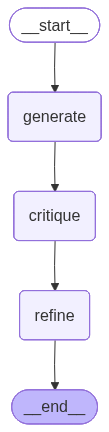

In [14]:
# Visualize the graph topology
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
# Run it
result = app.invoke({"product_name": "MeetingMind"})

print("=== Draft ===")
print(result["draft"])
print("\n=== Critique ===")
print(result["critique"])
print("\n=== Final Copy ===")
print(result["final_copy"])

=== Draft ===
# MeetingMind: Never Lose a Meeting Moment Again

Imagine walking out of every meeting with a crystal-clear record of exactly what was decided, who committed to what, and what needs to happen next — without lifting a finger. **MeetingMind** is your intelligent meeting assistant that quietly joins your video calls across Zoom, Teams, and Google Meet, listening and understanding conversations the way a brilliant colleague would. It doesn't just transcribe words; it *comprehends* them, distinguishing between casual conversation and critical decisions so nothing important ever slips through the cracks.

While you focus on the conversation that actually matters, MeetingMind works in the background, building a structured, searchable record of your meeting in real time. Its AI engine automatically identifies action items, flags deadlines, and assigns ownership to the right people — even when responsibilities are implied rather than stated directly. Miss a meeting? MeetingMind ha